In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/A_II_Emotion_Data_Student_Copy_Final.xlsx'
data1 = pd.read_excel(path)

In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5722 entries, 0 to 5721
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID_            5722 non-null   object
 1   brand_name_    5722 non-null   object
 2   country_       5722 non-null   object
 3   star_rating_   5722 non-null   int64 
 4   emotions_      627 non-null    object
 5   text_reviews_  5722 non-null   object
dtypes: int64(1), object(5)
memory usage: 268.3+ KB


Data preprocessing

In [5]:
pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=0cf1904f149fed5c1b9f9de829fa002970c3cab0bd05b4edc2bae35a6c3d34a5
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [6]:
#remove special characteres from the reviews
def clean_text1(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [7]:
data1['text_reviews_1'] = data1['text_reviews_'].apply(clean_text1)

In [8]:
#detecte languages in the reviews
from langdetect import detect, LangDetectException

def detectar_idioma(texto):
    try:
        return detect(texto)
    except LangDetectException:
        return "unknown"

data1["language"] = data1['text_reviews_1'].apply(detectar_idioma)
df_no_ingles = data1[data1['language'] != 'en']


In [9]:
total_en = (data1["language"] == "en").sum()

In [10]:
total_en

2828

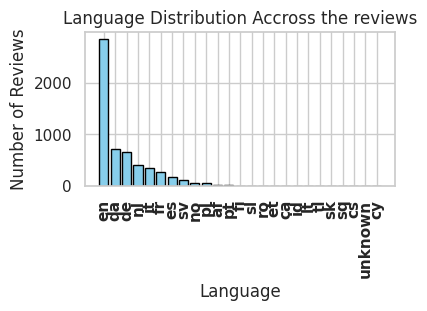

In [ ]:
#plot distribution of languages
language_counts = data1['language'].value_counts()

plt.figure(figsize=(4, 2))
plt.bar(language_counts.index, language_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.title('Language Distribution Accross the reviews')
plt.xticks(rotation=90, fontweight='bold')
plt.show()

In [11]:
#delete from the data set with no english reviews those reviews from GB to reduce the size of it
df_no_ingles1 = df_no_ingles[df_no_ingles['country_'] != 'GB']

In [13]:
df_no_ingles1 = df_no_ingles1.copy()

df_no_ingles1.loc[:, 'longitud'] = df_no_ingles1['text_reviews_1'].str.len()


total_caracteres = df_no_ingles1['longitud'].sum()

In [ ]:
total_caracteres

872239

In [14]:
# API deepl only allows 500000 for free, so the data set is divide and Baidu is also used
df_no_ingles1 = df_no_ingles1.copy()

df_no_ingles1.loc[:, 'length'] = df_no_ingles1['text_reviews_1'].str.len()
df_no_ingles1.loc[:, 'cumulative_length'] = df_no_ingles1['length'].cumsum()

df_filtered = df_no_ingles1[df_no_ingles1['cumulative_length'] <= 500000]
df_filtered2 = df_no_ingles1[df_no_ingles1['cumulative_length'] > 500000]

In [ ]:
#Translate the others 400000 characteres
import requests
from hashlib import md5
import random
import json
appid = '20240402002013298'
appkey = 'BRdzUuBl3BBAMC9es1d8'

def make_md5(s, encoding='utf-8'):
    return md5(s.encode(encoding)).hexdigest()

def baidu_api(query, from_lang='auto', to_lang='en'):
    endpoint = 'http://api.fanyi.baidu.com'
    path = '/api/trans/vip/translate'
    url = f"{endpoint}{path}"
    salt = random.randint(32768, 65536)
    sign = make_md5(appid + query + str(salt) + appkey)
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    payload = {
        'appid': appid,
        'q': query,
        'from': from_lang,
        'to': to_lang,
        'salt': salt,
        'sign': sign
    }

    try:
        r = requests.post(url, params=payload, headers=headers, timeout=10)
        result = r.json()
        if 'error_code' in result:
            print(f"Error {result['error_code']}: {result.get('error_msg', 'No error message')}")
            return query
        return result["trans_result"][0]['dst']
    except Exception as e:
        print(f"Error during translation: {e}")
        return query

def translate_text(text):
    return baidu_api(text, from_lang='auto', to_lang='en')

df_filtered2['translated_text'] = df_filtered2['text_reviews_1'].apply(translate_text)


<ipython-input-97-2d53a7afb9dc>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2['translated_text'] = df_filtered2['text_reviews_1'].apply(translate_text)


In [ ]:
#Translate the first 500000 characteres
import deepl

translator = deepl.Translator("ee87c8a8-fe26-4956-a1d6-bbe41f8590f1:fx")

def translate_text(text):
    try:
        result = translator.translate_text(text, target_lang="EN-GB")
        return result.text
    except Exception as e:
        print(f"Error al traducir el texto: {e}")
        return text

df_filtered['translated_text'] = df_filtered['text_reviews_1'].apply(translate_text)


<ipython-input-57-64258fe753ae>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['translated_text'] = df_filtered['text_reviews_1'].apply(translate_text)


In [ ]:
#adding the Deepl translated reviews to the original data set
result_df = pd.merge(data, df_filtered[['ID_', 'translated_text']], on='ID_', how='left')

result_df['text_reviews_'] = result_df['translated_text'].combine_first(result_df['text_reviews_'])

result_df.drop(['translated_text','text_reviews_1', 'language'], axis=1, inplace=True)

In [ ]:
#adding the Baidu translated reviews to the previous data set
merged_df = pd.merge(result_df, df_filtered2[['ID_', 'translated_text']], on='ID_', how='left')

merged_df['text_reviews_'] = merged_df['translated_text'].combine_first(merged_df['text_reviews_'])

final_df = merged_df.drop('translated_text', axis=1)

         ID_ brand_name_ country_  star_rating_ emotions_  \
0        ID1          Z_       US             5       NaN   
1       ID10          Z_       GB             5       NaN   
2      ID100          H_      FRI             5       joy   
3     ID1000          H_       GB             1      fear   
4     ID1001          H_       GB             1       NaN   
...      ...         ...      ...           ...       ...   
5717   ID995          H_       GB             1       NaN   
5718   ID996          H_       GB             1       NaN   
5719   ID997          H_       CY             1       NaN   
5720   ID998          H_       GB             1       NaN   
5721   ID999          H_       NL             1       NaN   

                                          text_reviews_  \
0     Fast shipping! All cloths was finally fits wel...   
1     Just wanted to say how delighted I was with th...   
2     My order took 6 days with a snow day and a wee...   
3     Wouldnt give them no star

In [ ]:
final_df.drop('Cleaned_reviews', axis=1, inplace=True)

New file with all the reviews in English

In [ ]:
path = '/content/drive/MyDrive/final_reviews.csv'
data = pd.read_csv(path)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5722 entries, 0 to 5721
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID_            5722 non-null   object
 1   brand_name_    5722 non-null   object
 2   country_       5722 non-null   object
 3   star_rating_   5722 non-null   int64 
 4   emotions_      627 non-null    object
 5   text_reviews_  5721 non-null   object
dtypes: int64(1), object(5)
memory usage: 268.3+ KB


In [ ]:
#remove 2 missing values originated when the reviews were translated
data = data.dropna(subset=['text_reviews_'])

In [ ]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=99e25f8c391f7c892a6794459beba32958ee05e05c21b55b426cbe66e4cbaf0f
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


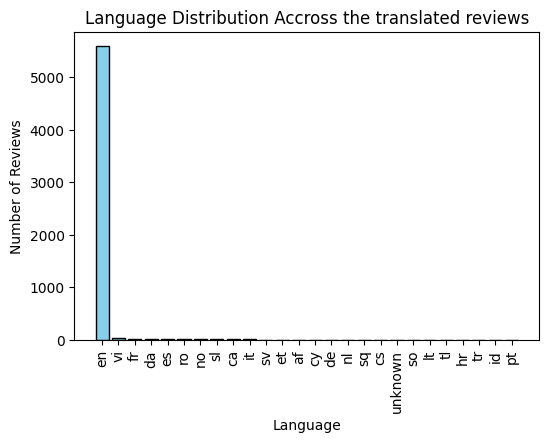

In [ ]:
#plot language distribution accross reviews
from langdetect import detect, LangDetectException

def detectar_idioma(texto):
    try:
        return detect(texto)
    except LangDetectException:
        return "unknown"

to_plot = data.copy()

to_plot["language"] = to_plot['text_reviews_'].apply(detectar_idioma)

language_counts = to_plot['language'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(language_counts.index, language_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.title('Language Distribution Accross the translated reviews')
plt.xticks(rotation=90)
plt.show()

Text Data Pre-Processing

In [ ]:
# function to do text pre-processing
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = text.lower()  # Lowercase text
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove words with 1 or 2 letters
    text = re.sub(r'[^a-z\s]', '', text)  # Keep text with letters and spaces

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize 0.56
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Stemming 0.54
    #stemmer = PorterStemmer()
    #tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [ ]:
# new column is created with the clean text
data['Cleaned_reviews'] = data['text_reviews_'].apply(clean_text)

Initial descriptive analysis

<ipython-input-9-d4bfa0b0788a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  count_plot = sns.countplot(y=column, data=data, palette="Set2")
<ipython-input-9-d4bfa0b0788a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=column, data=filtered_data, palette="Set2")
<ipython-input-9-d4bfa0b0788a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  count_plot = sns.countplot(y=column, data=data, palette="Set2")


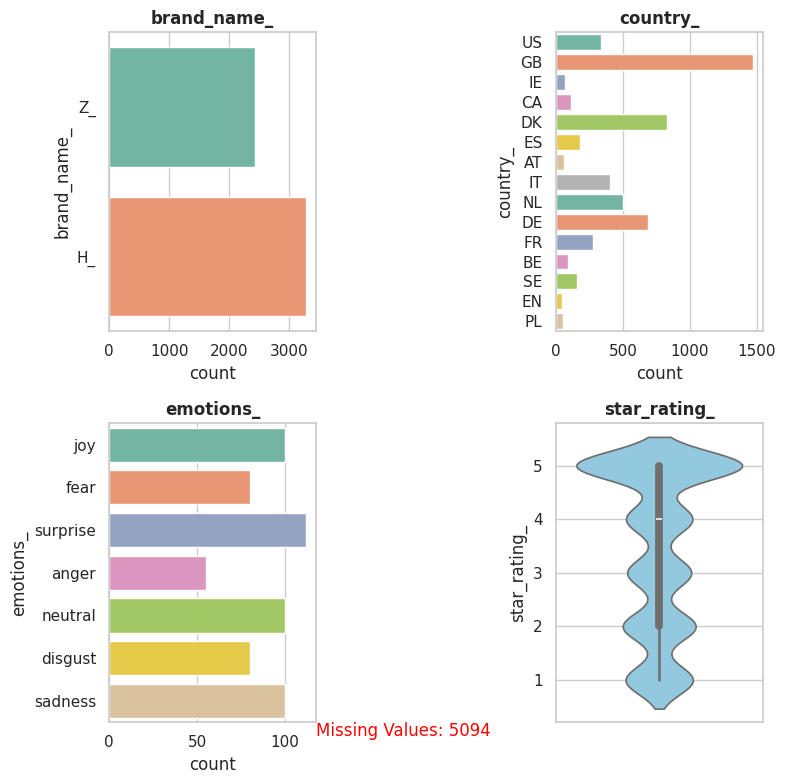

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

top_countries = data['country_'].value_counts().head(15).index
# Filtering the data to include only the top 15 countries
filtered_data = data[data['country_'].isin(top_countries)]
missing_emotions = data['emotions_'].isnull().sum()

# Adjusting the categorical columns to use the filtered data for country_
categorical_columns = ['brand_name_', 'country_', 'emotions_']
numerical_columns = ['star_rating_']

rows, cols = 2, 2

for index, column in enumerate(categorical_columns):
    plt.subplot(rows, cols, index + 1)
    # Ensure the plotting is done on 'filtered_data' for the 'country_' column
    if column == 'country_':
        sns.countplot(y=column, data=filtered_data, palette="Set2")
    else:
        count_plot = sns.countplot(y=column, data=data, palette="Set2")
    plt.title(f'{column}', fontweight='bold')
    plt.tight_layout()


    if column == 'emotions_':
        plt.text(count_plot.get_xlim()[1], count_plot.get_ylim()[0], f'Missing Values: {missing_emotions}',
                 horizontalalignment='left', verticalalignment='top',
                 fontsize=12, color='red')

plt.subplot(rows, cols, len(categorical_columns) + 1)
sns.violinplot(y='star_rating_', data=data, color="skyblue")
plt.title('star_rating_', fontweight='bold')
plt.tight_layout()

plt.show()

Machine Learning

Unlabeled data

In [ ]:
# data frame is created with missing observations of emotions (Unlabeled data) and Cleaned reviwes is included in the data frame.
unlabeled_data = data[pd.isna(data['emotions_'])][['Cleaned_reviews']]
unlabeled_data['emotions_'] = -1

Labeled Data

In [ ]:
# data frame is created with known observations of emotions (Labeled data) and Cleaned reviwes is included in the data frame.
labeled_data = data[data['emotions_'].notna()][['Cleaned_reviews', 'emotions_']]

Create X and y

In [ ]:
X = data['Cleaned_reviews']
y = data['emotions_']

In [ ]:
# known emotions
y_labeled = labeled_data['emotions_']
# missing emotions
y_unlabeled = unlabeled_data['emotions_']
# cleaned reviews for known emotions
X_labeled = labeled_data['Cleaned_reviews']
# cleaned reviews for missing emotions
X_unlabeled = unlabeled_data['Cleaned_reviews']

Function for calssification report

In [ ]:
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:", sum(1 for x in y_train if x == -1)) #if x == 'NaN'
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(
        "Micro-averaged F1 score on test set: %0.3f"
        % f1_score(y_test, y_pred, average="micro")
    )
    print("\nConfusion Matrix:\n", confusion_matrix(y_test,y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division=1))
    print("\n\n")

Split the labeled data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, stratify=y_labeled, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

TfidfVectorizer

In [ ]:
pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
import mglearn

def visualize_coefficients_multiclass_modified(coef_matrix, feature_names, class_labels, n_top_features=40):
    """
    Visualiza los coeficientes más importantes para cada clase, con los nombres de las clases en los títulos.

    :param coef_matrix: Matriz de coeficientes (clases x características).
    :param feature_names: Nombres de las características.
    :param class_labels: Etiquetas de las clases.
    :param n_top_features: Número de características más importantes para mostrar.
    """
    n_classes = coef_matrix.shape[0]

    for i in range(n_classes):
        plt.figure(figsize=(15, 5))
        coef = coef_matrix[i, :]
        mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features)
        plt.title(f"Clase {class_labels[i]}")  # Usar las etiquetas de clase reales para el título
        plt.show()

# Suponiendo que tienes un modelo llamado 'grid' que ya ha sido entrenado
class_labels = grid.best_estimator_.named_steps["logisticregression"].classes_
coeficientes = grid.best_estimator_.named_steps["logisticregression"].coef_
# Asegúrate de que 'feature_names' contiene los nombres de las características de tu modelo

# Ahora, llama a la función modificada con los nombres de las clases
visualize_coefficients_multiclass_modified(coeficientes, feature_names, class_labels, n_top_features=40)

ModuleNotFoundError: No module named 'mglearn'

BARD WORDS

In [ ]:
pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 7.4 MB/s eta 0:00:00


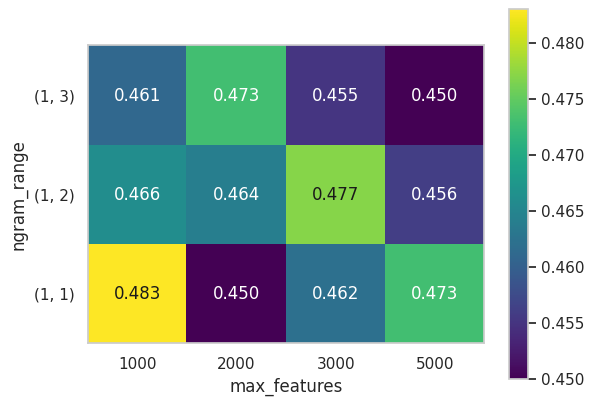

In [ ]:
import mglearn
pipe1 = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10000))

#Source: (Bird, S., Klein, E. and Loper, E. (2009) Natural language processing with python. Bejing: O’Reilly.)

#set parameter of logistic reression (C), based on previous calculation it is known that we required a high value for C
param_grid1 = {
    "logisticregression__C": [10, 100],
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "tfidfvectorizer__max_features": [1000, 2000, 3000, 5000]
}

grid1 = GridSearchCV(pipe1, param_grid1, cv=5)
grid1.fit(X_train, y_train)

scores = grid1.cv_results_['mean_test_score'].reshape(len(param_grid1["logisticregression__C"]),
                                                       len(param_grid1["tfidfvectorizer__ngram_range"]),
                                                       len(param_grid1["tfidfvectorizer__max_features"]))
scores_mean = scores.mean(axis=0)

heatmap = mglearn.tools.heatmap(scores_mean, xlabel="max_features", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
                                xticklabels=param_grid1["tfidfvectorizer__max_features"],
                                yticklabels=param_grid1["tfidfvectorizer__ngram_range"])

plt.colorbar(heatmap)
plt.show()

best ngram (1,1) por lo tanto la visualizacion y la agrupacion es igual que antes



**Supervised Machine learning** model for labelated data

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

vectorizer_params = {
    'ngram_range': (1, 2),
    'max_features': 3000
}

#hyper parameter tuning

param_grid = {
    "Random Forest": {
        "clf__n_estimators": [50, 100, 200],
        "clf__max_depth": [None, 10, 20, 30],
        "clf__min_samples_split": [2, 5, 10]
    },
    "K-Nearest Neighbors": {
        "clf__n_neighbors": [3, 5, 6, 7],
        "clf__weights": ["uniform", "distance"],
        "clf__algorithm": ["auto", "ball_tree"]
    },
    "Support Vector Machine": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf", "poly"]
    },
    "SDG": {
        "clf__alpha": [1e-5, 1e-4, 1e-3],
        "clf__penalty": ["l2", "l1"],
        "clf__loss": ["hinge", "log"]
    },
    "Naive Bayes": {
        "clf__alpha": [0.01, 0.1, 1.0]
    }
}


supervised_classifiers = [
    ("Random Forest", RandomForestClassifier(), param_grid["Random Forest"]),
    ("K-Nearest Neighbors", KNeighborsClassifier(), param_grid["K-Nearest Neighbors"]),
    ("Support Vector Machine", SVC(), param_grid["Support Vector Machine"]),
    ("SDG", SGDClassifier(), param_grid["SDG"]),
    ("Naive Bayes", MultinomialNB(), param_grid["Naive Bayes"])
]



classifier_names = []
accuracy_scores = []

for name, clf, params in supervised_classifiers:
    pipeline = Pipeline([
        ("vect", TfidfVectorizer(**vectorizer_params)),
        ("clf", clf),
    ])
    grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, cv=10)
    grid_search.fit(X_labeled, y_labeled)
    best_clf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print best hyperparameters
    print(f"Best Hyperparameters for {name}: {best_params}")

    # Evaluate and print metrics
    eval_and_print_metrics(best_clf, X_train, y_train, X_test, y_test)

    # Store the name and the accuracy for plotting
    classifier_names.append(name)
    accuracy_scores.append(best_score)


Best Hyperparameters for Random Forest: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Number of training samples: 501
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.611

Confusion Matrix:
 [[ 4  1  0  1  3  1  1]
 [ 1  9  0  2  3  1  0]
 [ 1  0  6  0  4  2  3]
 [ 0  0  0 18  0  1  1]
 [ 0  0  1  0 17  0  2]
 [ 0  3  1  1  7  8  0]
 [ 0  2  0  2  3  1 15]]

Classification Report:
               precision    recall  f1-score   support

       anger       0.67      0.36      0.47        11
     disgust       0.60      0.56      0.58        16
        fear       0.75      0.38      0.50        16
         joy       0.75      0.90      0.82        20
     neutral       0.46      0.85      0.60        20
     sadness       0.57      0.40      0.47        20
    surprise       0.68      0.65      0.67        23

    accuracy                           0.61       126
   macro avg       0.64      0.59      0.59       126
weighted avg  

In [ ]:
classifier_names = ["RF", "K-NN", "SVM", "SDG", "MNB"]

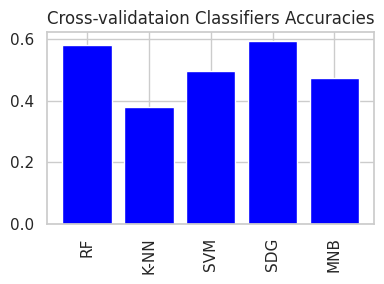

In [ ]:
# Plotting the accuracies
plt.figure(figsize=(4, 3))
plt.bar(classifier_names, accuracy_scores, color='blue')
plt.title('Cross-validataion Classifiers Accuracies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:


print("Classification Report:")
print(classification_report(y_test, y_pred1))

Classification Report:
              precision    recall  f1-score   support

       anger       0.43      0.27      0.33        11
     disgust       0.50      0.50      0.50        16
        fear       0.77      0.62      0.69        16
         joy       0.68      0.95      0.79        20
     neutral       0.50      0.70      0.58        20
     sadness       0.55      0.30      0.39        20
    surprise       0.70      0.70      0.70        23

    accuracy                           0.60       126
   macro avg       0.59      0.58      0.57       126
weighted avg       0.60      0.60      0.59       126



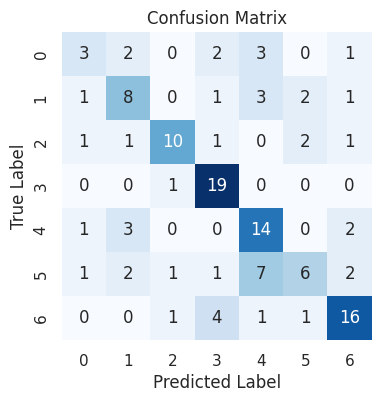

In [ ]:
best_params_sdg = { 'alpha': 0.001,'loss': 'log',
    'penalty': 'l1'}

pipeline_sdg = Pipeline([
    ("vect", TfidfVectorizer(**vectorizer_params)),
    ("clf", SGDClassifier(**best_params_sdg))
])

pipeline_sdg.fit(X_train, y_train)

y_pred1 = pipeline_sdg.predict(X_test)

cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
test_indices = X_test.index

# Exclude test data from X_labeled and y_labeled based on the identified indices
X_labeled_filtered = X_labeled.drop(index=test_indices, errors='ignore')
y_labeled_filtered = y_labeled.drop(index=test_indices, errors='ignore')

# Concatenate the filtered labeled data with the unlabeled data
# lop que se esta haciendo es extraer de X labeled e y labeled el test data test (me quedo con el train)
# se junta train labeled con toda la unlabeled por lo tanto tengo: X = x train label + all unlabeled. Y = y train labeled + all unlabeled
# x_test y y_test es todo labeled data para comprobar accuracy de las predicciones
X=X_combined = pd.concat([X_labeled_filtered, X_unlabeled])
y=y_combined = pd.concat([y_labeled_filtered, y_unlabeled])

In [ ]:
# Define the mapping for labels
label_mapping = {
    'anger': 0,
    'disgust': 1,
    'fear': 2,
    'joy': 3,
    'neutral': 4,
    'sadness': 5,
    'surprise': 6, -1:-1}

# Apply the mapping to labels
y  = [label_mapping[label] for label in y]
print(y)
y_test  = [label_mapping[label] for label in y_test]
print(y_test)

[3, 6, 0, 4, 1, 1, 6, 2, 3, 5, 1, 1, 5, 0, 2, 6, 5, 5, 5, 1, 2, 1, 1, 1, 0, 0, 5, 1, 5, 0, 6, 5, 1, 6, 6, 5, 1, 0, 4, 0, 1, 6, 2, 1, 5, 5, 4, 6, 2, 1, 1, 1, 0, 1, 3, 1, 5, 0, 6, 6, 5, 5, 6, 6, 6, 5, 6, 5, 2, 4, 1, 1, 2, 4, 1, 1, 4, 5, 2, 0, 5, 6, 0, 6, 5, 0, 5, 1, 3, 1, 1, 5, 6, 3, 1, 6, 1, 0, 0, 5, 5, 6, 5, 0, 0, 1, 3, 1, 6, 5, 5, 5, 6, 1, 2, 5, 1, 6, 0, 6, 3, 5, 2, 2, 5, 4, 3, 3, 6, 5, 2, 5, 3, 5, 5, 5, 2, 4, 4, 4, 2, 5, 1, 4, 2, 5, 3, 3, 3, 0, 4, 5, 4, 5, 2, 2, 5, 4, 5, 4, 6, 2, 3, 4, 1, 0, 3, 3, 3, 5, 0, 4, 3, 5, 1, 6, 2, 5, 6, 4, 6, 0, 4, 1, 4, 1, 6, 2, 6, 3, 5, 4, 3, 6, 1, 1, 3, 3, 4, 2, 6, 4, 6, 6, 6, 4, 0, 0, 2, 4, 6, 3, 4, 5, 5, 6, 2, 3, 3, 6, 3, 2, 2, 5, 6, 0, 6, 2, 1, 2, 3, 1, 4, 3, 3, 3, 6, 4, 6, 4, 4, 2, 6, 6, 6, 6, 6, 2, 3, 0, 2, 3, 6, 4, 4, 4, 3, 3, 4, 4, 5, 4, 3, 4, 0, 5, 6, 3, 4, 1, 5, 4, 2, 0, 3, 0, 0, 1, 4, 4, 5, 5, 6, 3, 1, 4, 3, 4, 6, 0, 6, 3, 4, 6, 0, 6, 6, 6, 4, 4, 2, 4, 3, 6, 3, 2, 5, 3, 6, 3, 6, 5, 2, 2, 1, 6, 4, 2, 5, 6, 3, 6, 3, 1, 3, 2, 6, 4, 4, 2, 6, 3, 2, 

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier

vectorizer_params = {
    'ngram_range': (1, 2),
    'max_features': 3000
}

random_state_seed = 40425150

# Defining classfiers with the best hyperparameter of supervised
non_graph_based_classifiers = [
    ("SelfTraining Logistic Regression", SelfTrainingClassifier(LogisticRegression(max_iter=1000), criterion='threshold', threshold=0.9)),
    ("SelfTraining K-Nearest Neighbors", SelfTrainingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=7, algorithm='auto', weights='distance'))),
    ("SelfTraining Naive Bayes", SelfTrainingClassifier(MultinomialNB())),
    ("SelfTraining SVC linear", SelfTrainingClassifier(SVC(probability=True, C=10, gamma='scale', kernel='linear'), criterion='threshold', threshold=0.9)),
    ("SelfTraining SDG", SelfTrainingClassifier(SGDClassifier(alpha=0.001, loss='log', penalty='l1'), verbose = True)),
    ("Random Forest", SelfTrainingClassifier(RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200)))
]


for name, clf in non_graph_based_classifiers:
    print(f"Evaluating {name}")
    st_pipeline = Pipeline([
        ("vect", TfidfVectorizer(**vectorizer_params)),
        ("clf", clf),
    ])
    eval_and_print_metrics(st_pipeline, X, y, X_test, y_test)


Evaluating SelfTraining Logistic Regression
Number of training samples: 5595
Unlabeled samples in training set: 5094
Micro-averaged F1 score on test set: 0.548

Confusion Matrix:
 [[ 3  1  0  2  2  2  1]
 [ 1  5  2  1  2  2  3]
 [ 0  2  5  1  2  3  3]
 [ 0  0  0 17  0  2  1]
 [ 0  0  0  0 14  0  6]
 [ 0  1  2  1  4  9  3]
 [ 0  1  0  1  1  4 16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.50      0.31      0.38        16
           2       0.56      0.31      0.40        16
           3       0.74      0.85      0.79        20
           4       0.56      0.70      0.62        20
           5       0.41      0.45      0.43        20
           6       0.48      0.70      0.57        23

    accuracy                           0.55       126
   macro avg       0.57      0.51      0.51       126
weighted avg       0.56      0.55      0.53       126




Evaluating SelfTraining K-

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

End of iteration 1, added 6 new labels.
End of iteration 2, added 9 new labels.
End of iteration 3, added 2 new labels.
Micro-averaged F1 score on test set: 0.619

Confusion Matrix:
 [[ 4  1  0  2  3  0  1]
 [ 1  8  0  0  5  2  0]
 [ 0  0 10  0  4  1  1]
 [ 0  0  0 19  0  1  0]
 [ 0  0  0  0 14  4  2]
 [ 0  0  2  3  4 10  1]
 [ 0  1  2  3  3  1 13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.80      0.50      0.62        16
           2       0.71      0.62      0.67        16
           3       0.70      0.95      0.81        20
           4       0.42      0.70      0.53        20
           5       0.53      0.50      0.51        20
           6       0.72      0.57      0.63        23

    accuracy                           0.62       126
   macro avg       0.67      0.60      0.61       126
weighted avg       0.66      0.62      0.62       126




Evaluating Random Fores

In [ ]:
from sklearn.semi_supervised import LabelSpreading

vectorizer_params = {
    'ngram_range': (1, 2),
    'max_features': 3000
}

ls_pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(**vectorizer_params)),
        ("toarray", FunctionTransformer(lambda x: x.toarray())),
        ("clf", LabelSpreading()),
    ]
)
ls_pipeline.fit(X, y)

eval_and_print_metrics(ls_pipeline, X, y, X_test, y_test)

Number of training samples: 5595
Unlabeled samples in training set: 5094
Micro-averaged F1 score on test set: 0.317

Confusion Matrix:
 [[ 0  1  0  0  1  0  9]
 [ 0  0  0  0  0  0 16]
 [ 0  0  3  0  0  0 13]
 [ 0  0  0  7  2  1 10]
 [ 0  0  0  1  3  0 16]
 [ 0  0  0  2  1  4 13]
 [ 0  0  0  0  0  0 23]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        11
           1       0.00      0.00      0.00        16
           2       1.00      0.19      0.32        16
           3       0.70      0.35      0.47        20
           4       0.43      0.15      0.22        20
           5       0.80      0.20      0.32        20
           6       0.23      1.00      0.37        23

    accuracy                           0.32       126
   macro avg       0.59      0.27      0.24       126
weighted avg       0.56      0.32      0.27       126






Best performance is Random Forest

In [ ]:
X_unlabeled

0          fast shipping cloth finally fit well satisfied
1       wanted say delighted friendly helpful staff me...
4       parcel never arrived chasing refund substantia...
5       avoid ordering online ordered day ago evri pac...
6       awful service returning item booked collection...
                              ...                        
5717    given star could known evri hermes courier wou...
5718    wanted change delivery location item within ho...
5719    waiting since believe sent order wrong country...
5720    complain late delivery horrendous compnay revi...
5721    placed order th november alert order could tak...
Name: Cleaned_reviews, Length: 5094, dtype: object

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

End of iteration 1, added 1 new labels.
End of iteration 2, added 5 new labels.
End of iteration 3, added 8 new labels.
End of iteration 4, added 3 new labels.
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.78      0.44      0.56        16
           2       0.62      0.62      0.62        16
           3       0.67      0.90      0.77        20
           4       0.45      0.70      0.55        20
           5       0.50      0.60      0.55        20
           6       0.73      0.48      0.58        23

    accuracy                           0.60       126
   macro avg       0.68      0.59      0.59       126
weighted avg       0.66      0.60      0.60       126



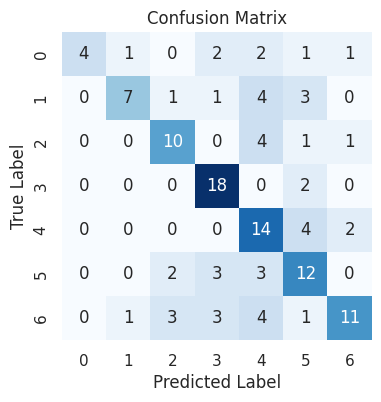

In [ ]:
st_svc_pipeline = Pipeline([
    ("vect", TfidfVectorizer(**vectorizer_params)),
    ("SelfTraining SGD", SelfTrainingClassifier(SGDClassifier(alpha=0.001, loss='log', penalty='l1'), verbose = True))])

st_svc_pipeline.fit(X, y)

y_pred2 = st_svc_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred2))

cm2 = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(4,4))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



Predicting with the supervised model

In [ ]:
predictions = st_svc_pipeline.predict(X_unlabeled)

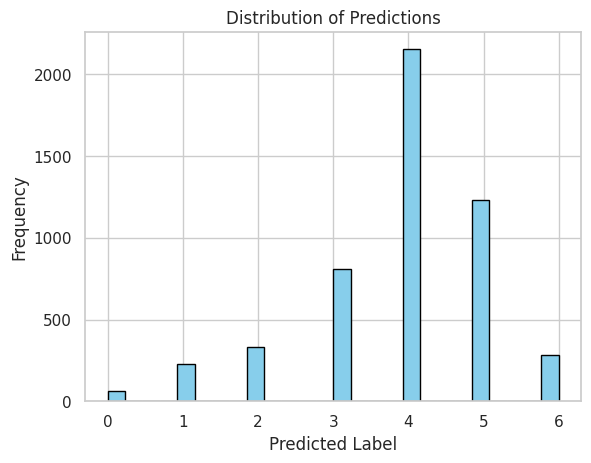

In [ ]:
plt.hist(predictions, bins='auto', color='skyblue', edgecolor='black')
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data1 = data.copy()

inverse_label_mapping = {v: k for k, v in label_mapping.items()}

text_predictions = np.array([inverse_label_mapping[pred] for pred in predictions])

missing_emotion_indices = data1[data1['emotions_'].isna()].index

assert len(predictions) == len(missing_emotion_indices)

data1.loc[missing_emotion_indices, 'emotions_'] = text_predictions

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5721 entries, 0 to 5721
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID_              5721 non-null   object
 1   brand_name_      5721 non-null   object
 2   country_         5721 non-null   object
 3   star_rating_     5721 non-null   int64 
 4   emotions_        5721 non-null   object
 5   text_reviews_    5721 non-null   object
 6   Cleaned_reviews  5721 non-null   object
dtypes: int64(1), object(6)
memory usage: 486.6+ KB


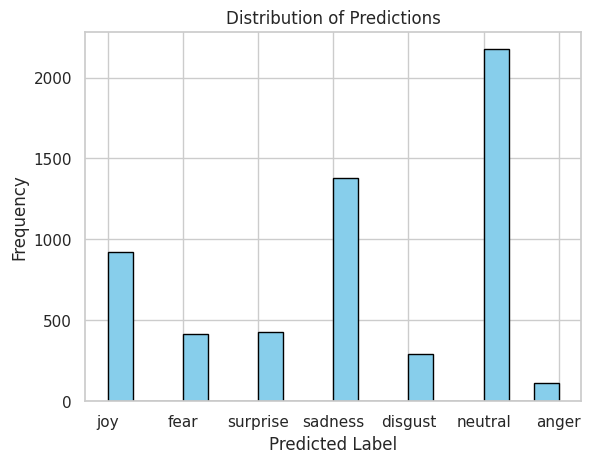

In [ ]:
plt.hist(data1['emotions_'], bins='auto', color='skyblue', edgecolor='black')
figsize=(7, 7)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('Frequency')
plt.xticks(fontweight = "bold")
plt.show()

ANALYSIS OF BRAND

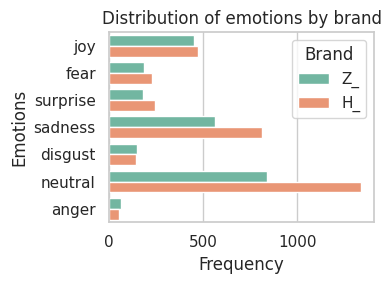

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de conteo de emociones por marca
plt.figure(figsize=(4, 3))
sns.countplot(y='emotions_', hue='brand_name_', data=data1, palette='Set2')
plt.title('Distribution of emotions by brand')
plt.xlabel('Frequency')
plt.ylabel('Emotions')
plt.legend(title='Brand')
plt.tight_layout()
plt.show()

In [ ]:
total_emotions_per_brand = data1.groupby('brand_name_').size().reset_index(name='total_per_brand')

# Count each emotion per brand
emotion_counts = data1.groupby(['brand_name_', 'emotions_']).size().reset_index(name='counts')

# Merge the total counts into emotion counts to calculate percentages
emotion_counts = emotion_counts.merge(total_emotions_per_brand, on='brand_name_')

# Calculate percentage
emotion_counts['percentage'] = 100 * emotion_counts['counts'] / emotion_counts['total_per_brand']

# Check the updated DataFrame
print(emotion_counts)

   brand_name_ emotions_  counts  total_per_brand  percentage
0           H_     anger      51             3291    1.549681
1           H_   disgust     143             3291    4.345184
2           H_      fear     227             3291    6.897600
3           H_       joy     473             3291   14.372531
4           H_   neutral    1339             3291   40.686721
5           H_   sadness     813             3291   24.703737
6           H_  surprise     245             3291    7.444546
7           Z_     anger      63             2430    2.592593
8           Z_   disgust     149             2430    6.131687
9           Z_      fear     188             2430    7.736626
10          Z_       joy     449             2430   18.477366
11          Z_   neutral     836             2430   34.403292
12          Z_   sadness     565             2430   23.251029
13          Z_  surprise     180             2430    7.407407


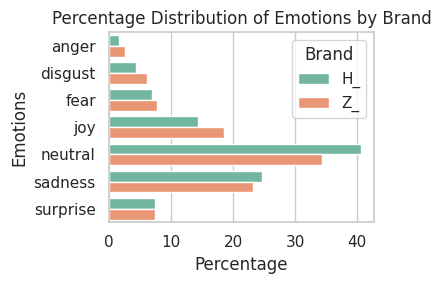

In [ ]:
sns.set(style="whitegrid")

# Create a bar plot to visualize percentages
plt.figure(figsize=(4, 3))
sns.barplot(x='percentage', y='emotions_', hue='brand_name_', data=emotion_counts, palette='Set2')
plt.title('Percentage Distribution of Emotions by Brand')
plt.xlabel('Percentage')
plt.ylabel('Emotions')
plt.legend(title='Brand')
plt.tight_layout()
plt.show()

<ipython-input-63-8165b5e4ea0e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='star_rating_', y='brand_name_', data=data1, palette='Set3')


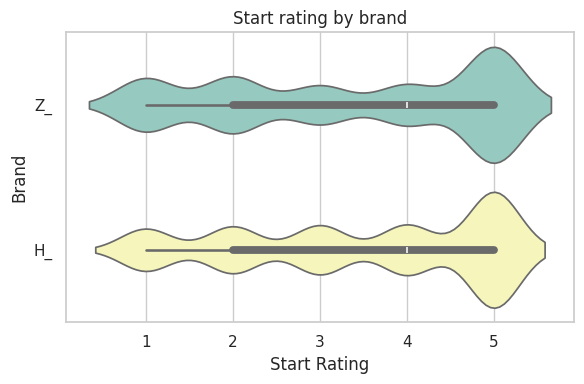

In [ ]:

plt.figure(figsize=(6, 4))
sns.violinplot(x='star_rating_', y='brand_name_', data=data1, palette='Set3')
plt.title('Start rating by brand')
plt.xlabel('Start Rating')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()


<ipython-input-64-bae6a365a426>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='star_rating_', y='emotions_', data=brand_data, palette='Set3')


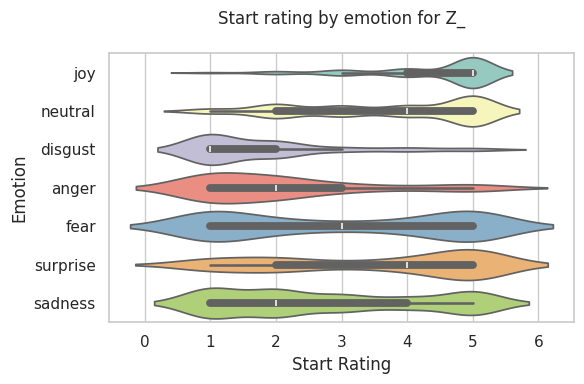

<ipython-input-64-bae6a365a426>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='star_rating_', y='emotions_', data=brand_data, palette='Set3')


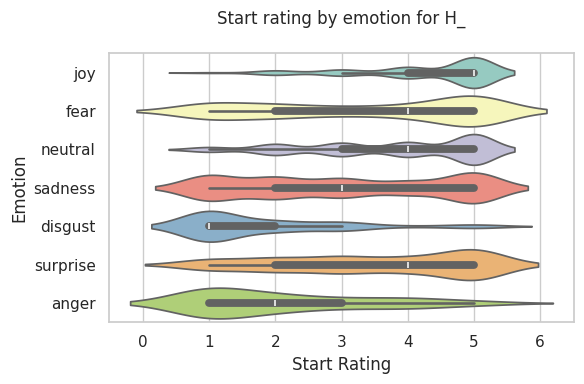

In [ ]:
brands = data1['brand_name_'].unique()

for brand in brands:
    # Filter the dataset for the current brand
  brand_data = data1[data1['brand_name_'] == brand]
  plt.figure(figsize=(6, 4))
  sns.violinplot(x='star_rating_', y='emotions_', data=brand_data, palette='Set3')
  plt.title(f'Start rating by emotion for {brand}\n')
  plt.xlabel('Start Rating')
  plt.ylabel('Emotion')
  plt.tight_layout()
  plt.show()


In [ ]:
# Preparar los datos
X_train, X_test, y_train, y_test = train_test_split(data1['Cleaned_reviews'], data1['emotions_'], test_size=0.2, random_state=42)

# Crear un pipeline con TF-IDF y Regresión Logística
model = make_pipeline(TfidfVectorizer(**vectorizer_params), LogisticRegression(max_iter=10000, C=10))

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       anger       1.00      0.26      0.41        27
     disgust       0.72      0.45      0.55        65
        fear       0.72      0.50      0.59        72
         joy       0.82      0.78      0.80       174
     neutral       0.77      0.90      0.83       446
     sadness       0.69      0.77      0.73       290
    surprise       0.69      0.38      0.49        71

    accuracy                           0.75      1145
   macro avg       0.77      0.58      0.63      1145
weighted avg       0.75      0.75      0.74      1145



In [ ]:
pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 7.3 MB/s eta 0:00:00


Classification Report for Brand: Z_

              precision    recall  f1-score   support

       anger       0.86      0.43      0.57        14
     disgust       0.67      0.31      0.42        39
        fear       0.69      0.51      0.59        39
         joy       0.74      0.76      0.75        75
     neutral       0.74      0.91      0.81       180
     sadness       0.63      0.69      0.66       108
    surprise       0.40      0.19      0.26        31

    accuracy                           0.70       486
   macro avg       0.67      0.54      0.58       486
weighted avg       0.69      0.70      0.68       486



<Figure size 800x400 with 0 Axes>

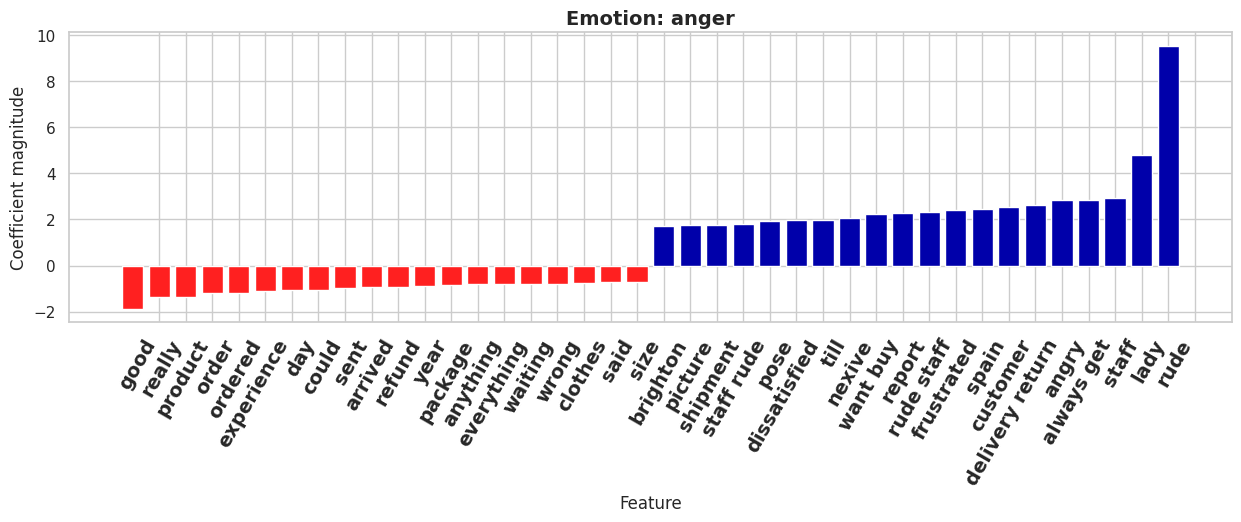

<Figure size 800x400 with 0 Axes>

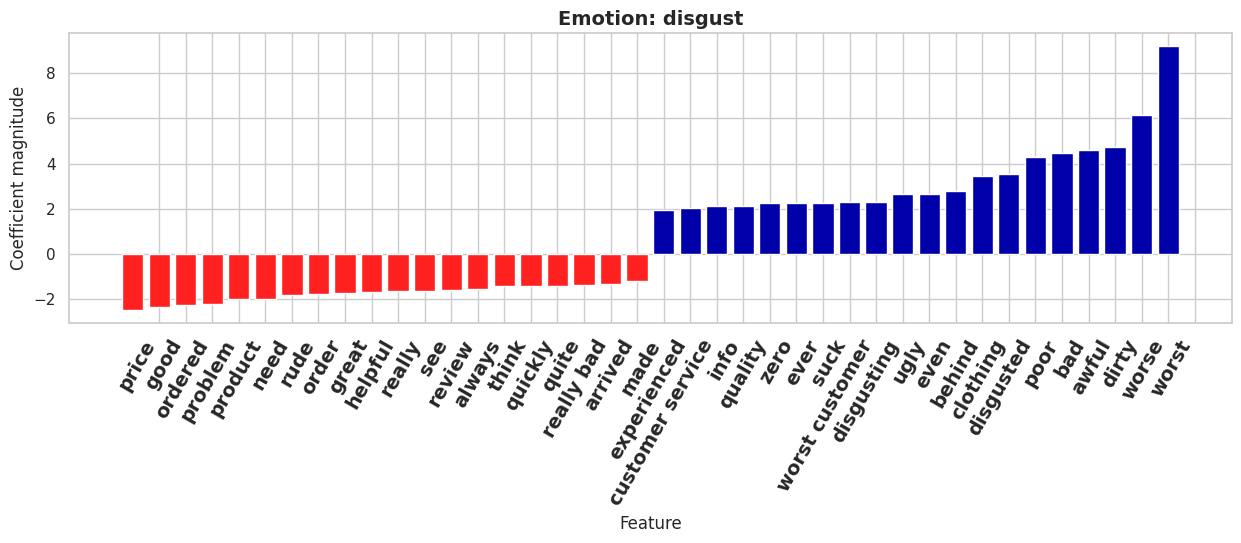

<Figure size 800x400 with 0 Axes>

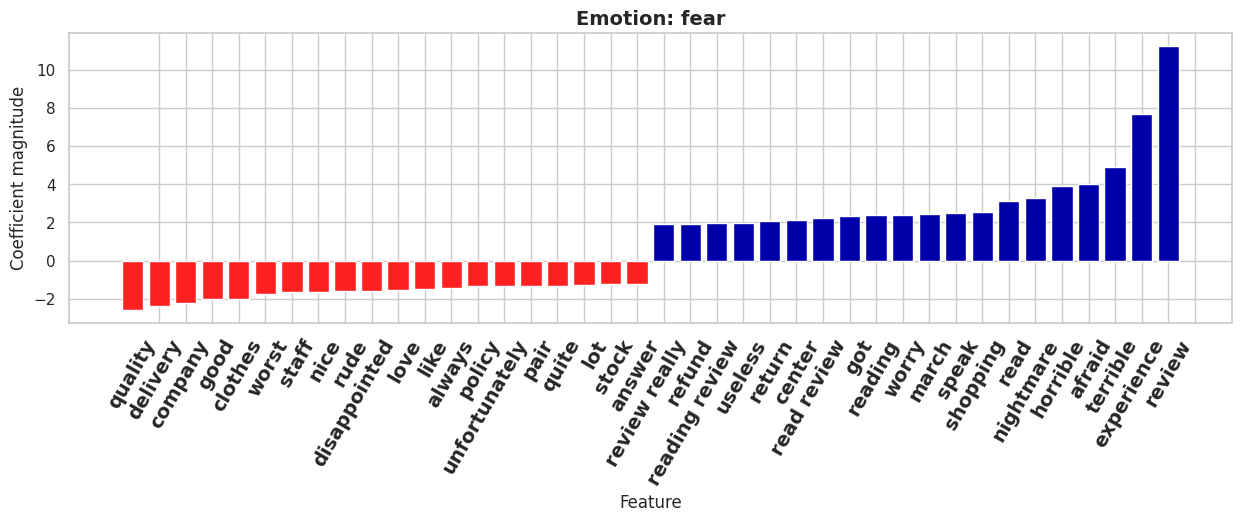

<Figure size 800x400 with 0 Axes>

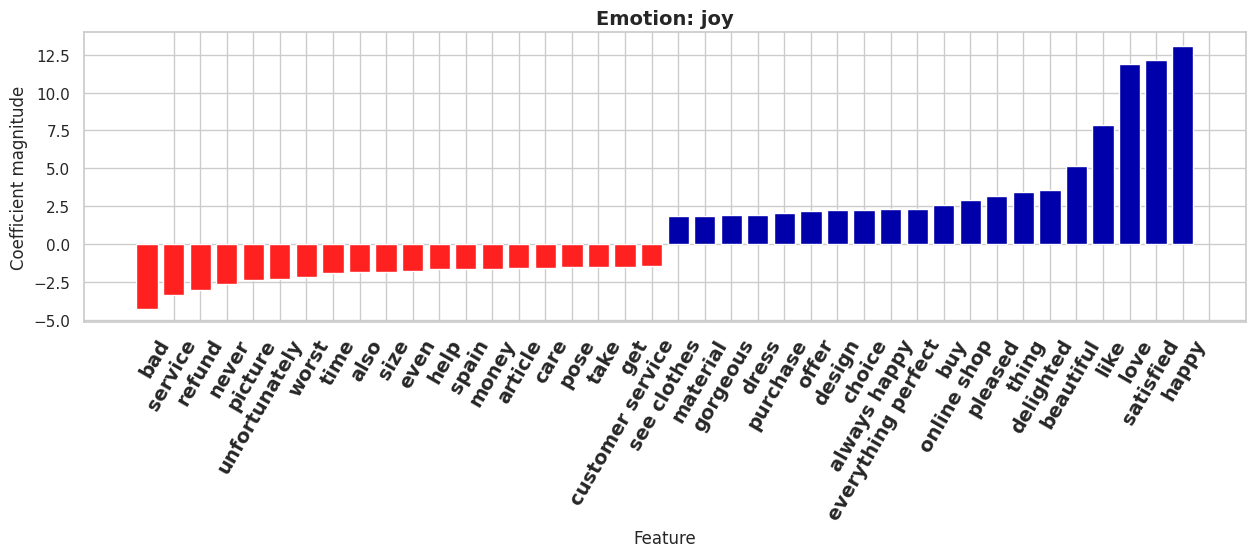

<Figure size 800x400 with 0 Axes>

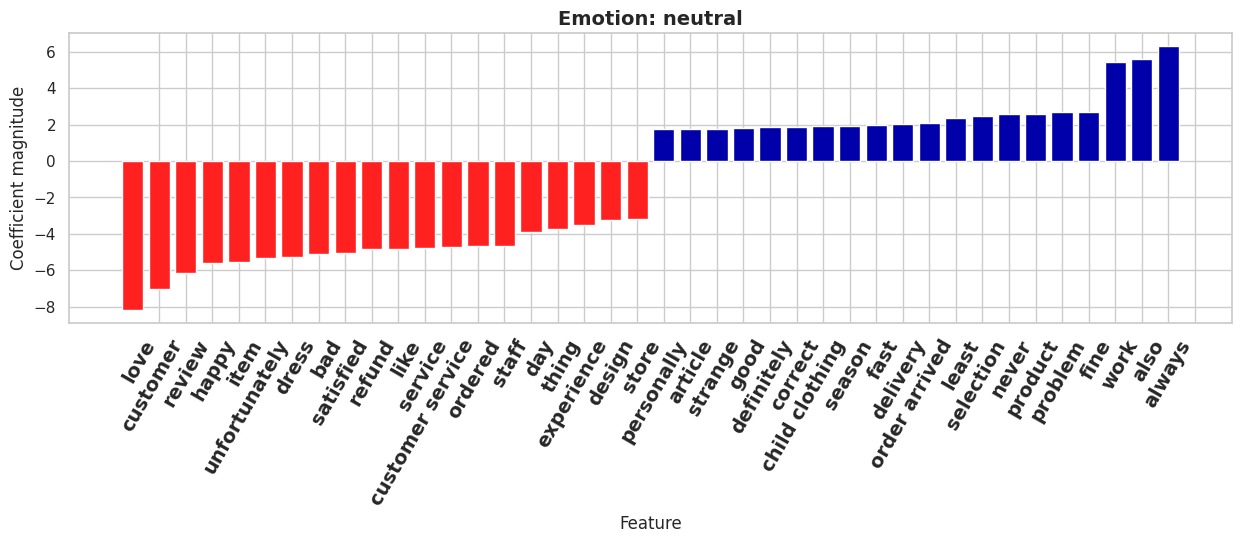

<Figure size 800x400 with 0 Axes>

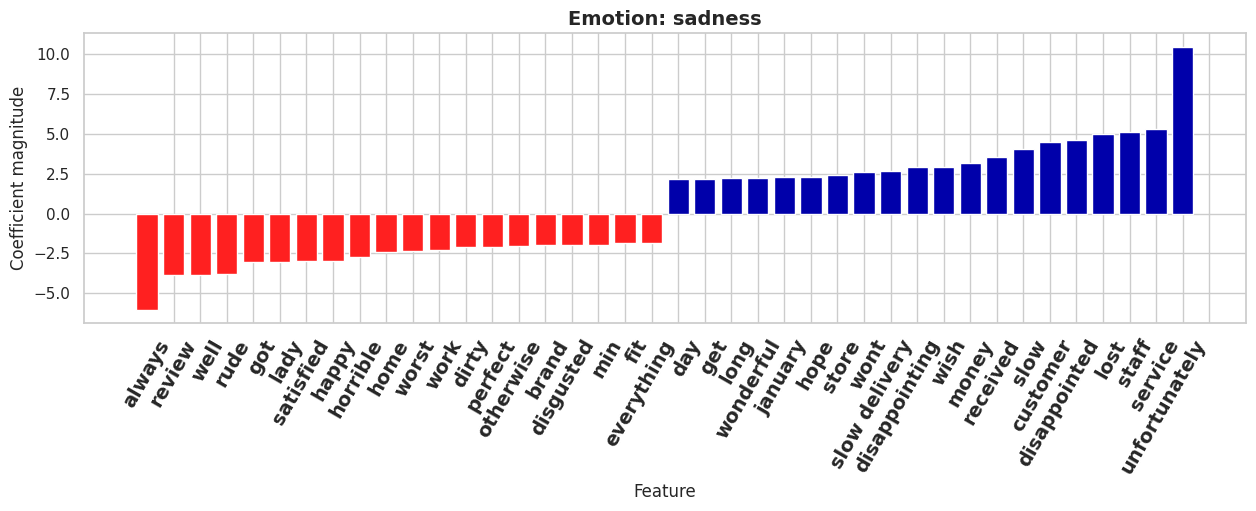

<Figure size 800x400 with 0 Axes>

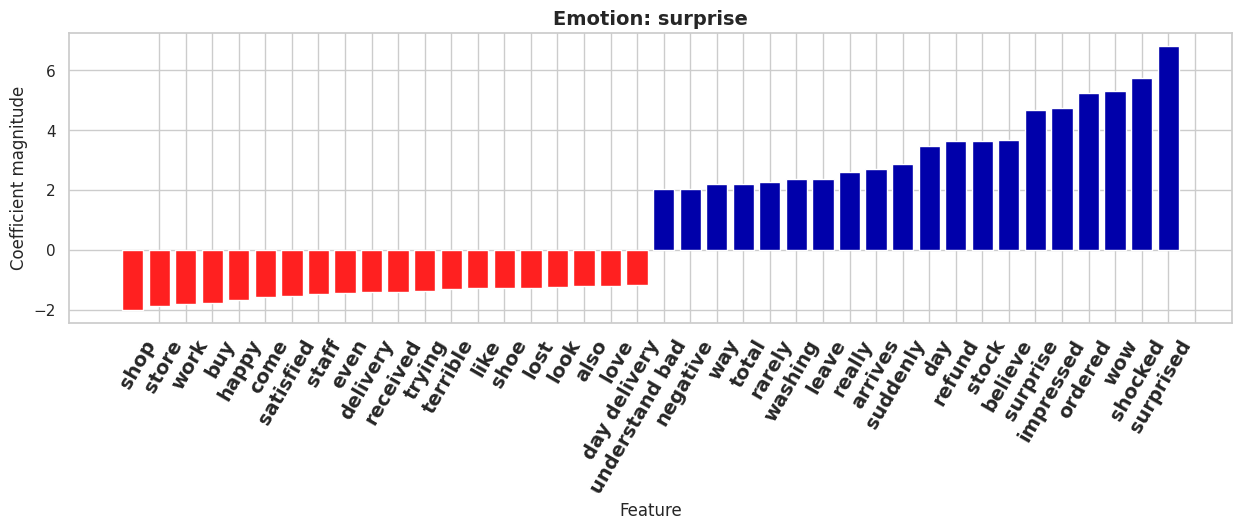

Classification Report for Brand: H_

              precision    recall  f1-score   support

       anger       1.00      0.10      0.18        10
     disgust       0.71      0.18      0.29        28
        fear       0.54      0.39      0.45        38
         joy       0.85      0.69      0.76        98
     neutral       0.77      0.90      0.83       278
     sadness       0.64      0.78      0.70       160
    surprise       0.62      0.34      0.44        47

    accuracy                           0.73       659
   macro avg       0.73      0.48      0.52       659
weighted avg       0.73      0.73      0.71       659



<Figure size 800x400 with 0 Axes>

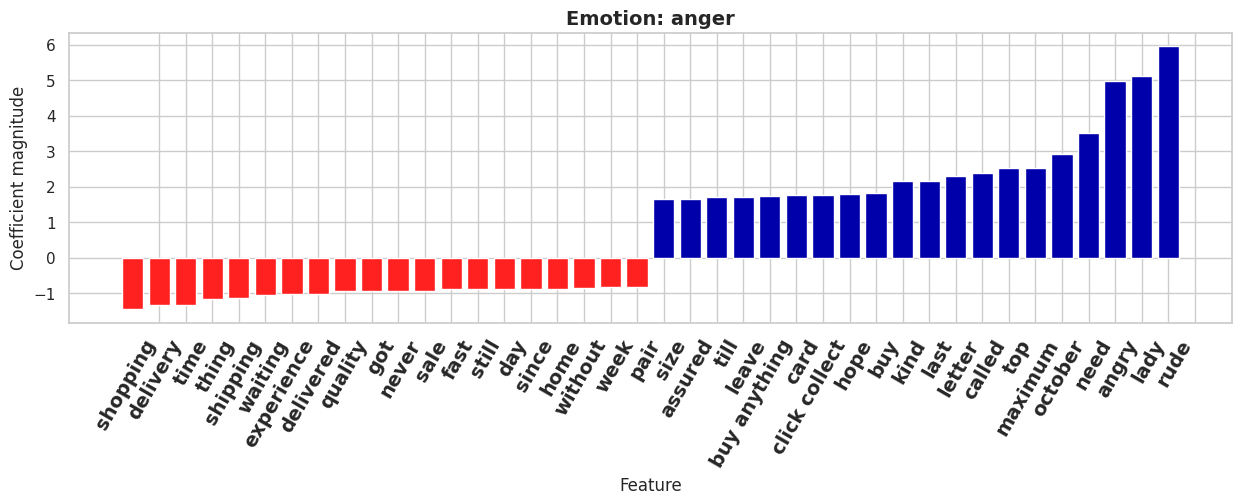

<Figure size 800x400 with 0 Axes>

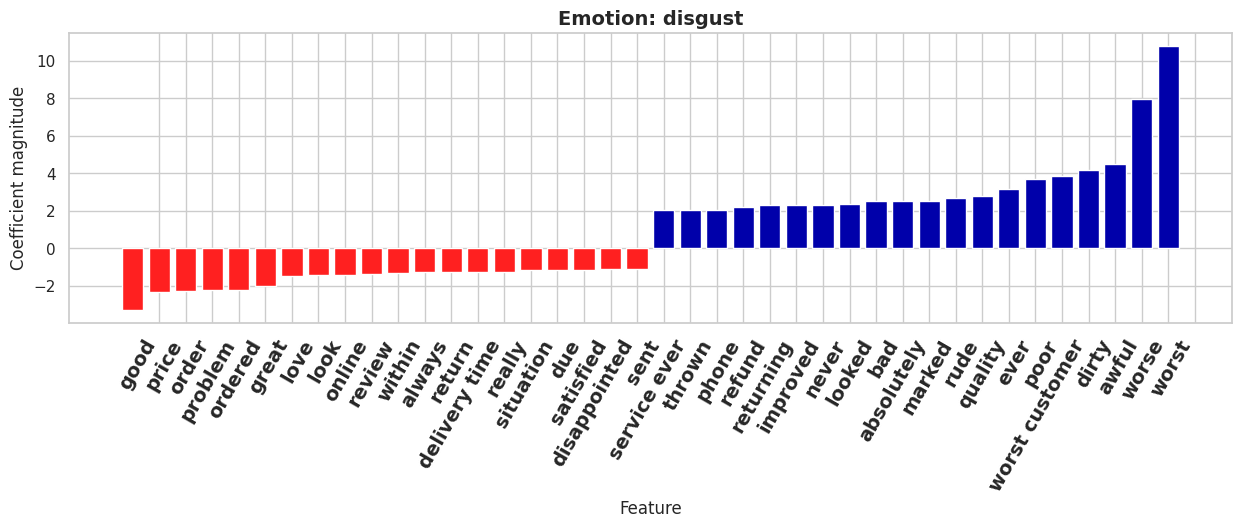

<Figure size 800x400 with 0 Axes>

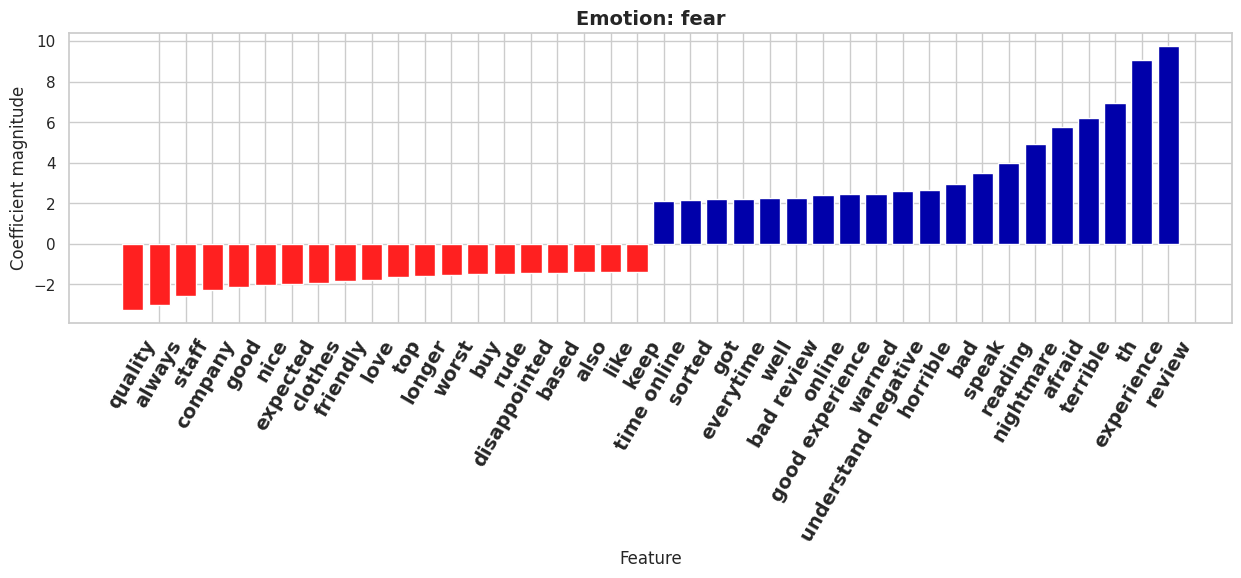

<Figure size 800x400 with 0 Axes>

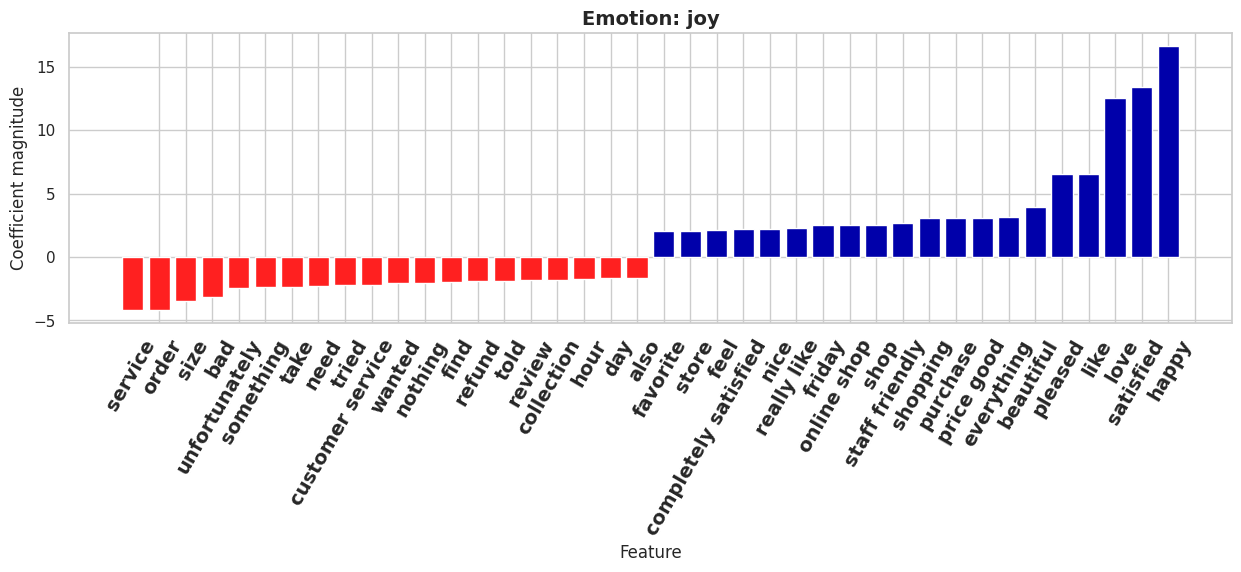

<Figure size 800x400 with 0 Axes>

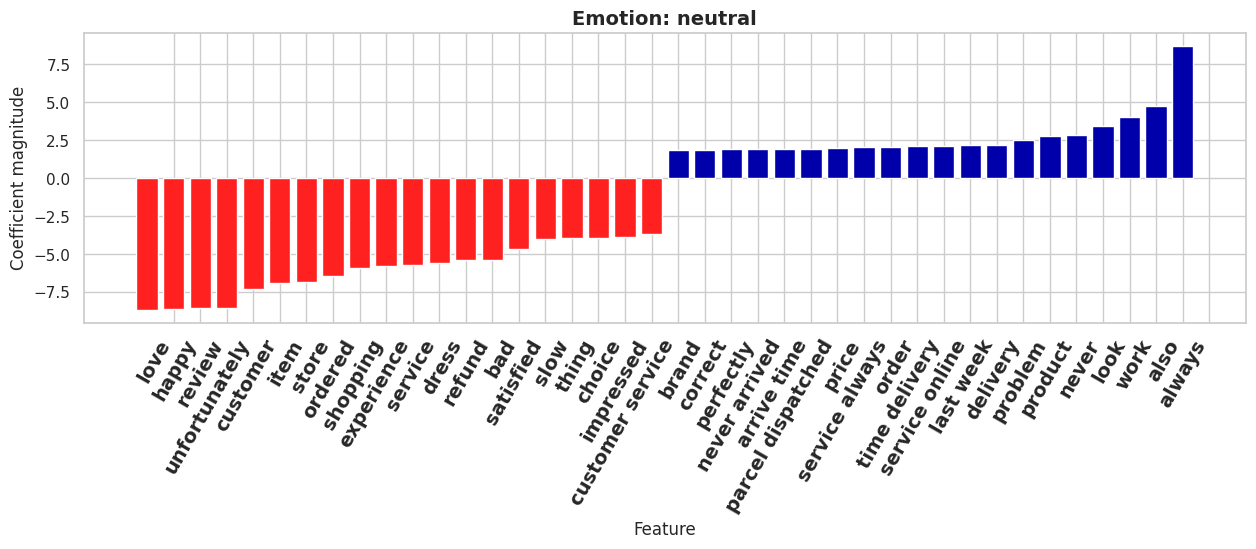

<Figure size 800x400 with 0 Axes>

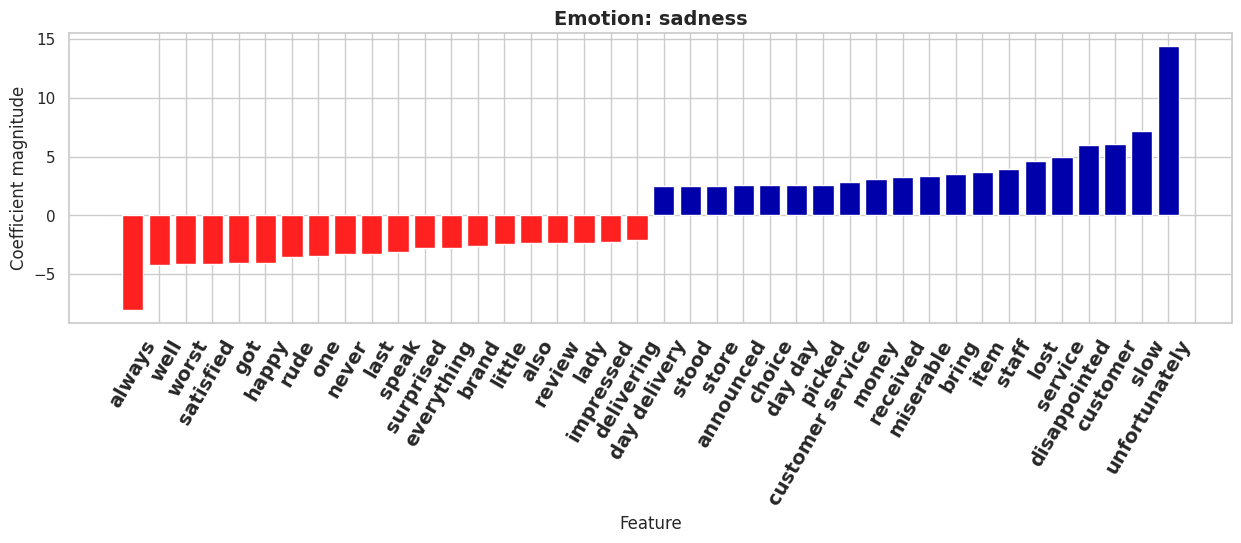

<Figure size 800x400 with 0 Axes>

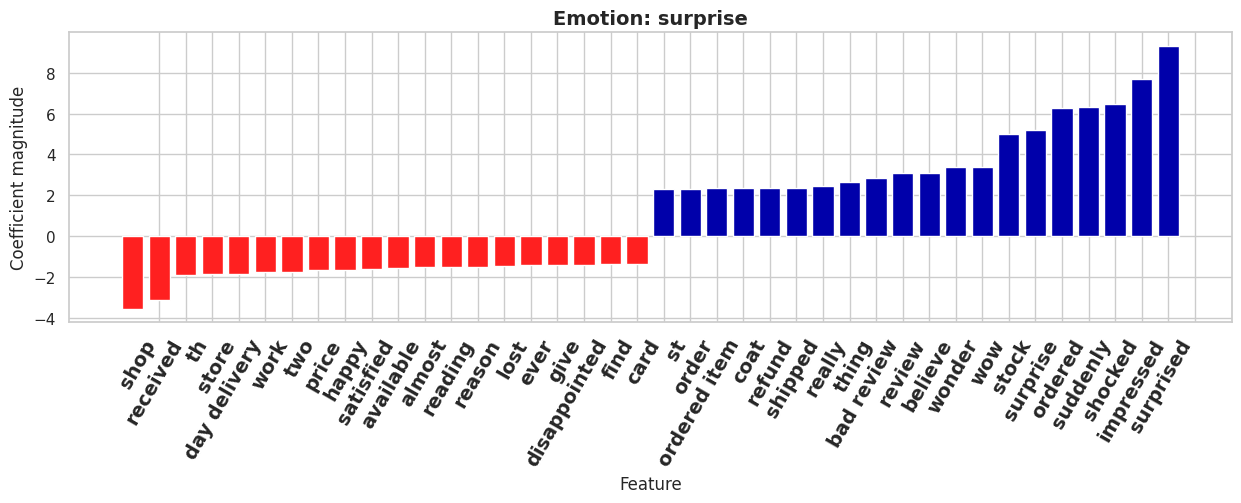

In [ ]:
import mglearn

def visualize_coefficients_multiclass_modified(coef_matrix, feature_names, class_labels, n_top_features=20):
    n_classes = coef_matrix.shape[0]
    for i in range(n_classes):
        plt.figure(figsize=(8, 4))
        coef = coef_matrix[i, :]
        mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=n_top_features)
        plt.title(f"Emotion: {class_labels[i]}", fontsize=14, fontweight='bold')
        plt.xticks(fontsize=14, fontweight='bold')
        plt.show()

# Loop through each brand to train and evaluate a model

for brand in brands:
    # Filter the dataset for the current brand
    brand_data = data1[data1['brand_name_'] == brand]


    # Prepare the data
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        brand_data['Cleaned_reviews'], brand_data['emotions_'], test_size=0.2, random_state=42
    )

    # Create a pipeline with TF-IDF and Logistic Regression
    model = make_pipeline(TfidfVectorizer(**vectorizer_params), LogisticRegression(max_iter=10000, C=10))

    # Train the model
    model.fit(X_train2, y_train2)

    # Evaluate the model
    predictions = model.predict(X_test2)
    print(f"Classification Report for Brand: {brand}\n")
    print(classification_report(y_test2, predictions))

    # Visualization of coefficients
    vect = model.named_steps['tfidfvectorizer']
    features_names = np.array(vect.get_feature_names_out())
    coef = model.named_steps['logisticregression'].coef_
    class_labels = model.named_steps['logisticregression'].classes_
    visualize_coefficients_multiclass_modified(coef, features_names, class_labels, n_top_features=20)